In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
from rasterio.transform import from_bounds
from rasterio.plot import show

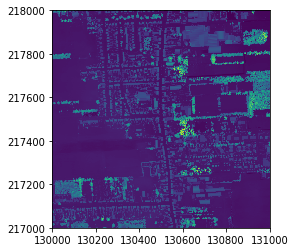

In [4]:
# open the cropped tif we wrote
crop = rio.open("./cut.tif")
# plot the cropped tif
show(crop)

In [15]:
def cropper(origin_arr, origin_meta, new_name, x, y, width, height, origin_bounds):
    left = int(x * width)
    right = int((x+1) * width)
    bottom = int((y+1) * height)
    top = int(y * height)
        
    new_left = origin_bounds.left + left
    new_right = origin_bounds.left + right
    new_bottom = origin_bounds.top - bottom
    new_top = origin_bounds.top - top
    
    print(f"[{x},{y}]: {new_left}{new_right}|{new_bottom}{new_top}")
    # crop out of the array
    new_arr = origin_arr[left:right,top:bottom]

    # transform needs to be edited so the crop has correct coords
    origin_meta["transform"] = from_bounds(
        # new left-most coord
        new_left, 
        # new bottom-most coord
        new_bottom, 
        # new right-most coord
        new_right, 
        # new top-most coord
        new_top, 
        # new width
        width,
        # new height
        height)
    
    new_path = os.path.join("/media/seppe/DiskSpaceInvader/3DHouseData",new_name)
    # open a new file in write mode as destination
    # **meta is the **kwargs passed to the tif
    with rio.open(new_name, "w", **origin_meta) as destination:
        # write the pixel data with the **meta data
        destination.write(new_arr, indexes=1)
        print("new file: ",new_name)
        destination.close()
    return


def splitter(tiff_path:str, div:int, name:str):
    tiff = rio.open(tiff_path)
    tiff_arr = np.array(tiff.read(1))
    tiff_meta = tiff.meta
    origin_bounds = tiff.bounds
    origin_width = origin_bounds.right - origin_bounds.left
    origin_height = origin_bounds.top - origin_bounds.bottom
    print(origin_width, origin_height)
    if (origin_width%div == 0) and (origin_height%div == 0):
        width_div = origin_width/div
        height_div = origin_height/div
        for i in range(div):
            for j in range(div):                
                # call the cropper function, with a new filename, and the current i and j
                cropper(tiff_arr, tiff_meta, 
                        f"{name}cutx{i}y{j}.tif", 
                        i, j, 
                        width_div, height_div, origin_bounds)
        tiff.close()
        os.remove(tiff_path)
    else:
        print("error in: ", tiff_path, " These bounds can't be divided by ", str(div))
    return

    
# splitter("../Data/DHMVIIDSMRAS1m_k10/GeoTIFF/DHMVIIDSMRAS1m_k10.tif",10)

12000.0 9000.0
[0,0]: 226000.0227200.0|226100.0227000.0
new file:  ./cutx0y0.tif
[0,1]: 226000.0227200.0|225200.0226100.0
new file:  ./cutx0y1.tif
[0,2]: 226000.0227200.0|224300.0225200.0
new file:  ./cutx0y2.tif
[0,3]: 226000.0227200.0|223400.0224300.0
new file:  ./cutx0y3.tif
[0,4]: 226000.0227200.0|222500.0223400.0
new file:  ./cutx0y4.tif
[0,5]: 226000.0227200.0|221600.0222500.0
new file:  ./cutx0y5.tif
[0,6]: 226000.0227200.0|220700.0221600.0
new file:  ./cutx0y6.tif
[0,7]: 226000.0227200.0|219800.0220700.0
new file:  ./cutx0y7.tif
[0,8]: 226000.0227200.0|218900.0219800.0
new file:  ./cutx0y8.tif
[0,9]: 226000.0227200.0|218000.0218900.0
new file:  ./cutx0y9.tif
[1,0]: 227200.0228400.0|226100.0227000.0
new file:  ./cutx1y0.tif
[1,1]: 227200.0228400.0|225200.0226100.0
new file:  ./cutx1y1.tif
[1,2]: 227200.0228400.0|224300.0225200.0
new file:  ./cutx1y2.tif
[1,3]: 227200.0228400.0|223400.0224300.0
new file:  ./cutx1y3.tif
[1,4]: 227200.0228400.0|222500.0223400.0
new file:  ./cutx1y4

In [ ]:
# ================ Maarten's Cropper ===================

# tif path
k15_path = "/media/seppe/DiskSpaceInvader/3DHouseData/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif"
# open and store tif
k15_tif = rio.open(k15_path)
# pixel data from tif
k15_data = np.array(k15_tif.read(1))
# meta data form tif
k15_meta = k15_tif.meta
print(f"original tif meta data: {k15_meta}")
# lamber72 box of tif
k15_bounds = k15_tif.bounds
print(f"original tif bounds: {k15_bounds}")


# open the cropped tif we wrote
crop = rio.open("./cut.tif")
# plot the cropped tif
show(crop)
# print the cropped meta data
print(f"cropped tif meta data: {crop.meta}")
# print the cropped bounds
print(f"cropped tif bounds: {crop.bounds}")